In [1]:
%autosave 0

Autosave disabled


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('..')

from lib.classifier_trainer import MainAiJob
from lib.data_explore import DataExplore
from lib import consume_validation

# Import ML modele packages
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

from sklearn import svm
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler

from joblib import dump

Using TensorFlow backend.


In [4]:
df = pd.read_csv("../Data/app_hover_public.csv")

In [5]:
df.shape

(59472, 29)

In [6]:
pd.set_option('display.max_columns', 50)

In [7]:
df.sample(5)

,Steam_id,Title,Date_release,Evaluation,Nb_Eval,Nb_game_tags,Game_Tag_1,Game_Tag_2,Game_Tag_3,Game_Tag_4,Game_Tag_5,App_cat,Dev_team,Publisher_team,Os_supported,Prymary_genre,Controller_support,Is_free_app,Nb_language,Workshop_visible,Only_vr_support,Vr_support,Has_adult_content,Nb_achievements,Single_player,Coop_player,Multi_player,Early_Access,Price
43140,970800,Short Circuit VR,2018-11-19,Very Positive,59,4,Indie,Simulation,Early Access,VR,NaN,Game,Stefan Bauwens,NaN,1,Simulation,0,1,1,0,1,1,0,0,1,0,0,1,0.00
2902,255920,The 7th Guest,2013-10-18,Mixed,410,12,Adventure,Point &amp; Click,Horror,Puzzle,FMV,Game,Trilobyte Games,Nightdive Studios,4,Adventure,0,0,2,0,0,0,0,0,1,0,0,0,0.00
53826,1171030,Bock Bock,2020-04-15,No,0,7,Racing,Strategy,Indie,Gambling,Turn-Base,Game,Ben Fitzpatrick,Ben Fitzpatrick,1,Strategy,0,0,2,0,0,0,1,11,1,0,1,0,5.69
7605,359710,From Bedrooms to Billions: Making Head Over Heels,2016-09-15,No,0,4,Game Development,Documentary,Retro,Gaming,NaN,Video,NaN,NaN,4,NaN,1,0,8,0,0,0,0,0,0,0,0,0,0.00
16193,514930,Super Hop 'N' Bop ULTRA,2016-10-17,No,0,5,Action,Indie,Casual,Retro,2D,Game,CTgames,Flying Interactive,1,Indie,0,0,3,0,0,0,0,19,0,0,1,0,1.99


# Data engineering

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59472 entries, 0 to 59471
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Steam_id            59472 non-null  int64  
 1   Title               59469 non-null  object 
 2   Date_release        59472 non-null  object 
 3   Evaluation          59472 non-null  object 
 4   Nb_Eval             59472 non-null  int64  
 5   Nb_game_tags        59472 non-null  int64  
 6   Game_Tag_1          59472 non-null  object 
 7   Game_Tag_2          55273 non-null  object 
 8   Game_Tag_3          47807 non-null  object 
 9   Game_Tag_4          38489 non-null  object 
 10  Game_Tag_5          31347 non-null  object 
 11  App_cat             59445 non-null  object 
 12  Dev_team            56931 non-null  object 
 13  Publisher_team      57492 non-null  object 
 14  Os_supported        59472 non-null  int64  
 15  Prymary_genre       58419 non-null  object 
 16  Cont

In [9]:
dataviz = DataExplore(df,'Nb_Eval')
dataviz.count_na()

,Total,Null_Count,Percent
Game_Tag_5,59472,28125,47.29
Game_Tag_4,59472,20983,35.28
Game_Tag_3,59472,11665,19.61
Game_Tag_2,59472,4199,7.06
Dev_team,59472,2541,4.27
Publisher_team,59472,1980,3.33
Prymary_genre,59472,1053,1.77
App_cat,59472,27,0.05
Title,59472,3,0.01


Notre target n'exite pas vraiment, on a des produits qui ont soit 0 evaluation soit X.

On va donc créer notre target et définire soit 0 pour 1 soit 1 pour X

In [10]:
def apply_status_reco(df):
    if df['Nb_Eval'] >= 1:
        return 1
    else:
        return 0
    
def apply_value_reco(df):
    """create Output phase 2 """
    if 'Positive' in df['Evaluation']:
        return 1
    else:
        return 0     

In [11]:
df['status_reco'] = df.apply(apply_status_reco, axis=1)
df['Value_reco'] = df.apply(apply_value_reco, axis=1)

In [12]:
df.columns

Index(['Steam_id', 'Title', 'Date_release', 'Evaluation', 'Nb_Eval',
       'Nb_game_tags', 'Game_Tag_1', 'Game_Tag_2', 'Game_Tag_3', 'Game_Tag_4',
       'Game_Tag_5', 'App_cat', 'Dev_team', 'Publisher_team', 'Os_supported',
       'Prymary_genre', 'Controller_support', 'Is_free_app', 'Nb_language',
       'Workshop_visible', 'Only_vr_support', 'Vr_support',
       'Has_adult_content', 'Nb_achievements', 'Single_player', 'Coop_player',
       'Multi_player', 'Early_Access', 'Price', 'status_reco', 'Value_reco'],
      dtype='object')

In [13]:
## drop les colonnes qui n'apporte pas de valeur à notre projet et remplacer les manquants, 
## mais aussi les colonnes qu'ont aura pas au moment de la prediction (les game tag) et surtout celles qui apportent un élément 
## de réponse par exemple si on garde la colonne qui dit que les revieuw sont trés positives, 
##ca veut dire qu'il y'en a il ne faut pas garder cette information.


df_clean = df.drop(columns=['Steam_id','Title', 'Date_release', 
                            'Game_Tag_1','Game_Tag_2', 'Game_Tag_3', 'Game_Tag_4', 'Game_Tag_5',
                           'Nb_game_tags'])


In [14]:
df_clean["App_cat"].unique()

array(['Game', 'Legacy Media', 'Application', 'Demo', 'Config', nan,
       'Downloadable Content', 'Tool', 'Music', 'Unknown', 'Video',
       'Series', 'Hardware'], dtype=object)

In [15]:
## parmis toute les categories on veut garder uniquement les jeux

df_clean = df_clean[df_clean["App_cat"].isin(["Game", "Downloadable Content",  "Demo"])]

In [16]:
## je transforme les colonnes dev et publisher en information utilisable, au lieu du nom on prend le nombres de produits
## publiés.

df_clean['exp_dev_team'] = df_clean.groupby('Dev_team')['Dev_team'].transform('count')
df_clean['exp_publish_team'] = df_clean.groupby('Publisher_team')['Publisher_team'].transform('count')

In [17]:
## je rajoute une colonne, si les dev et publisher sont les même = 1 sinon 0 (édité par un tier)
def apply_self_editing(df):
    """create feature self editing """
    if df['Dev_team'] == df['Publisher_team']:
        return 1
    else:
        return 0

In [18]:
df_clean['Self_editor'] = df_clean.apply(apply_self_editing, axis=1)

In [19]:
## je fixe mes values pour le fillna

values = {'exp_dev_team': 0, 'exp_publish_team': 0, 'Prymary_genre': 'Unknown Genre', 'App_cat': 'Unknown'}
df_clean = df_clean.fillna(value=values);

In [20]:
## et je ne conserve pas ces cat 
df_clean = df_clean.drop(columns=['Dev_team','Publisher_team'])

In [21]:
df_clean.columns

Index(['Evaluation', 'Nb_Eval', 'App_cat', 'Os_supported', 'Prymary_genre',
       'Controller_support', 'Is_free_app', 'Nb_language', 'Workshop_visible',
       'Only_vr_support', 'Vr_support', 'Has_adult_content', 'Nb_achievements',
       'Single_player', 'Coop_player', 'Multi_player', 'Early_Access', 'Price',
       'status_reco', 'Value_reco', 'exp_dev_team', 'exp_publish_team',
       'Self_editor'],
      dtype='object')

In [22]:
convert_to_bool = ["Controller_support","Is_free_app","Workshop_visible","Only_vr_support",
                   "Vr_support","Has_adult_content",'Single_player',
                  'Coop_player', 'Multi_player', 'Early_Access','Self_editor']

for col in convert_to_bool:
    df_clean[col] = df_clean[col].astype('bool')

In [23]:
# Example du schema de data final 
df_clean.sample()

,Evaluation,Nb_Eval,App_cat,Os_supported,Prymary_genre,Controller_support,Is_free_app,Nb_language,Workshop_visible,Only_vr_support,Vr_support,Has_adult_content,Nb_achievements,Single_player,Coop_player,Multi_player,Early_Access,Price,status_reco,Value_reco,exp_dev_team,exp_publish_team,Self_editor
5395,Mixed,19,Game,4,Adventure,True,False,2,False,False,False,False,7,True,False,False,False,6.99,1,0,1.0,3.0,False


# Data exploration

In [24]:
dataviz = DataExplore(df_clean,'status_reco')

In [25]:
dataviz.count_na()

,Total,Null_Count,Percent


In [26]:
df_clean.shape

(54447, 23)

In [27]:
corr = df_clean.corr().abs()
corr.status_reco[corr.status_reco >= 0.01].sort_values(ascending=False)

status_reco           1.000000
Value_reco            0.714005
exp_dev_team          0.170121
exp_publish_team      0.154683
Nb_language           0.154013
Is_free_app           0.140932
Price                 0.134881
Self_editor           0.128449
Workshop_visible      0.117083
Single_player         0.110059
Nb_achievements       0.074519
Controller_support    0.067065
Coop_player           0.061253
Os_supported          0.057750
Multi_player          0.039188
Nb_Eval               0.035116
Early_Access          0.032109
Has_adult_content     0.030868
Only_vr_support       0.019076
Name: status_reco, dtype: float64

In [28]:
cols_cat = dataviz._infer_cat_columns()
cols_cat 

['Evaluation',
 'App_cat',
 'Prymary_genre',
 'Controller_support',
 'Is_free_app',
 'Workshop_visible',
 'Only_vr_support',
 'Vr_support',
 'Has_adult_content',
 'Single_player',
 'Coop_player',
 'Multi_player',
 'Early_Access',
 'Self_editor']

In [29]:
col_num = dataviz._infer_num_columns()
col_num

['Nb_Eval',
 'Os_supported',
 'Nb_language',
 'Nb_achievements',
 'Price',
 'status_reco',
 'Value_reco',
 'exp_dev_team',
 'exp_publish_team']

In [30]:
col_num.remove('status_reco') ## notre target

In [31]:
data_dummies, col_dum = dataviz._infer_dummies_columns()
col_dum

Index(['Controller_support', 'Is_free_app', 'Workshop_visible',
       'Only_vr_support', 'Vr_support', 'Has_adult_content', 'Single_player',
       'Coop_player', 'Multi_player', 'Early_Access', 'Self_editor',
       'Evaluation_Mostly Negative', 'Evaluation_Mostly Positive',
       'Evaluation_Negative', 'Evaluation_No',
       'Evaluation_Overwhelmingly Negative',
       'Evaluation_Overwhelmingly Positive', 'Evaluation_Positive',
       'Evaluation_Very Negative', 'Evaluation_Very Positive',
       'App_cat_Downloadable Content', 'App_cat_Game',
       'Prymary_genre_Adventure', 'Prymary_genre_Animation & Modeling',
       'Prymary_genre_Audio Production', 'Prymary_genre_Casual',
       'Prymary_genre_Design & Illustration', 'Prymary_genre_Early Access',
       'Prymary_genre_Education', 'Prymary_genre_Free to Play',
       'Prymary_genre_Game Development', 'Prymary_genre_Gore',
       'Prymary_genre_Indie', 'Prymary_genre_Massively Multiplayer',
       'Prymary_genre_Nudity', 'Pry

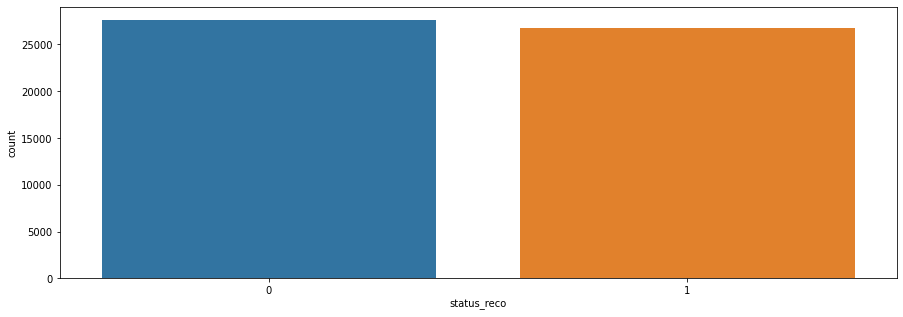

Nombres de sujet positifs :  26789  = 49.2 %
Nombres de sujet negatifs :  27658  = 50.8 %


In [32]:
panel_pos, panel_neg = dataviz.distribution_binaries()

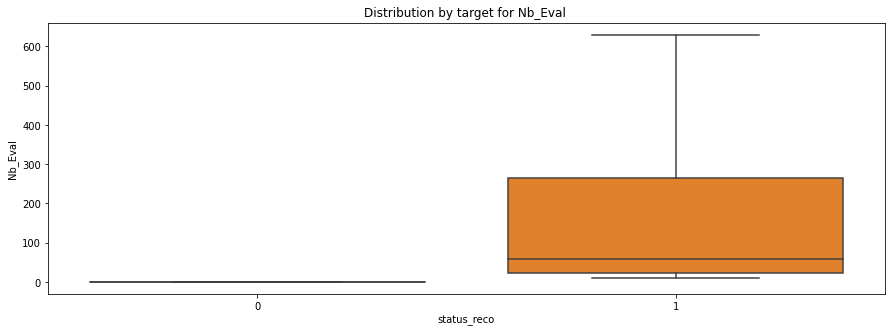

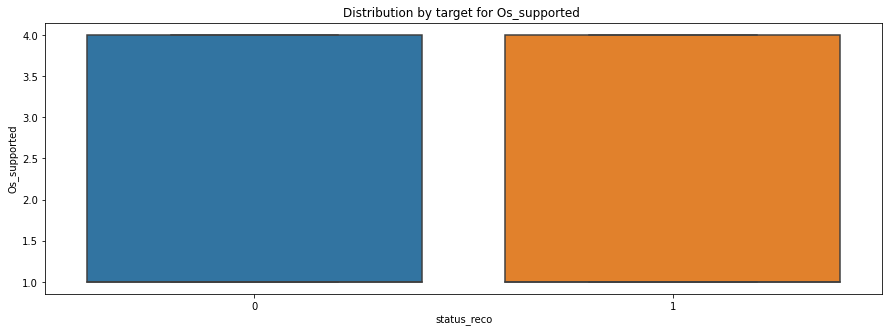

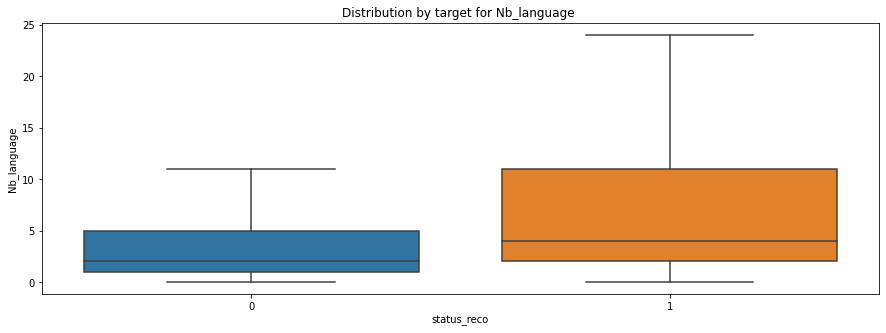

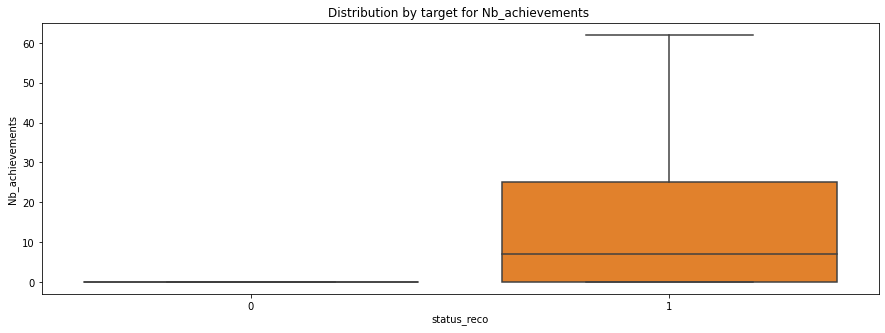

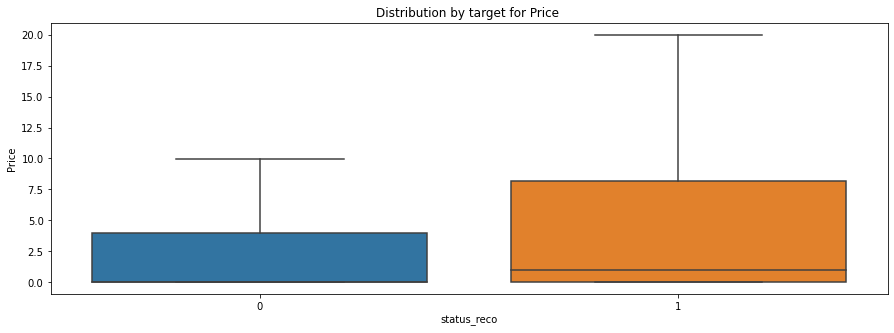

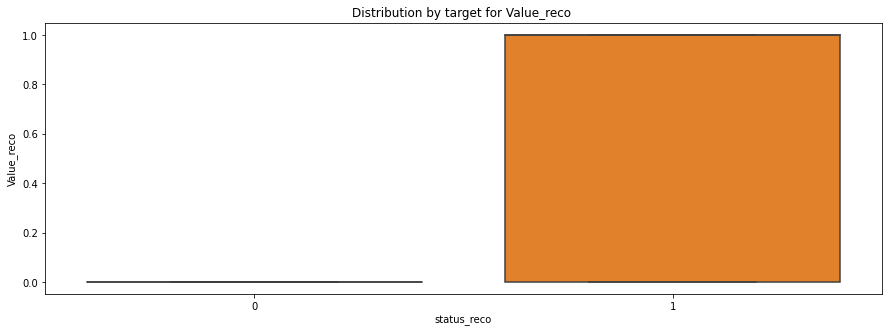

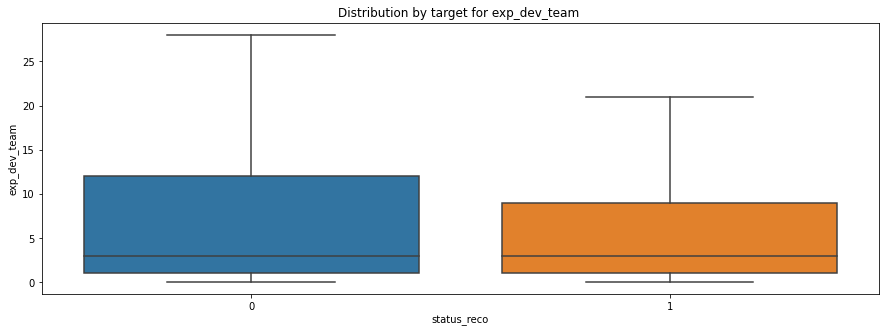

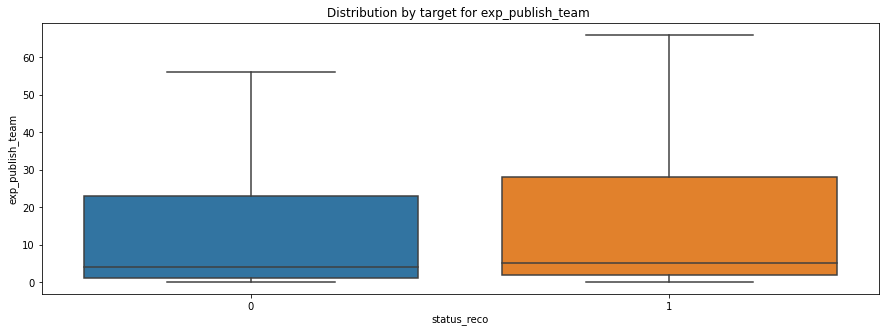

In [33]:
dataviz.all_num_features_distribution(show_outliers=False)

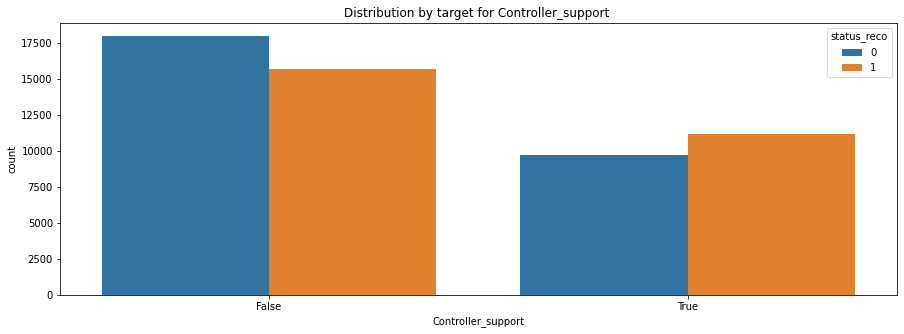

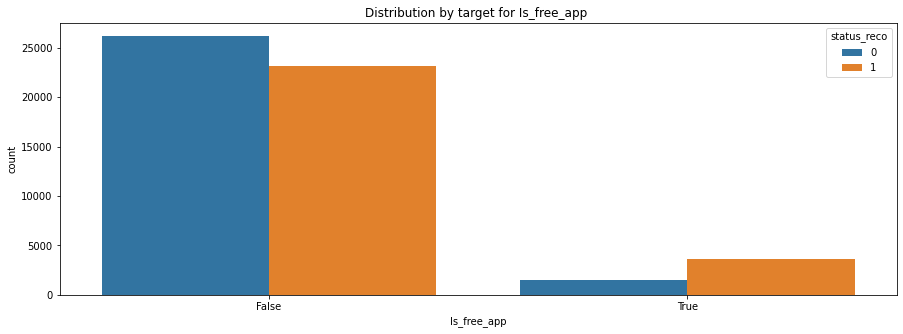

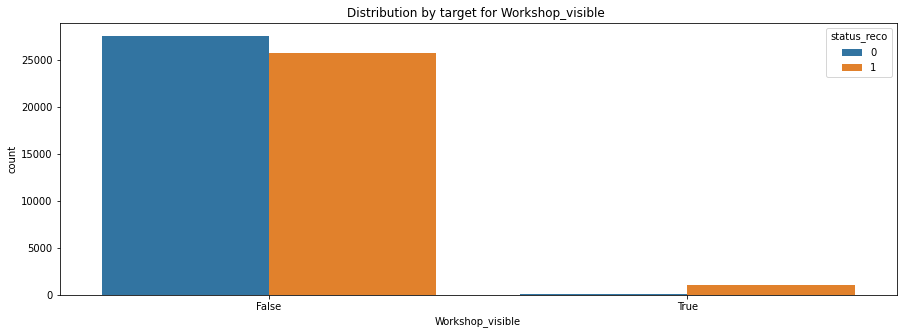

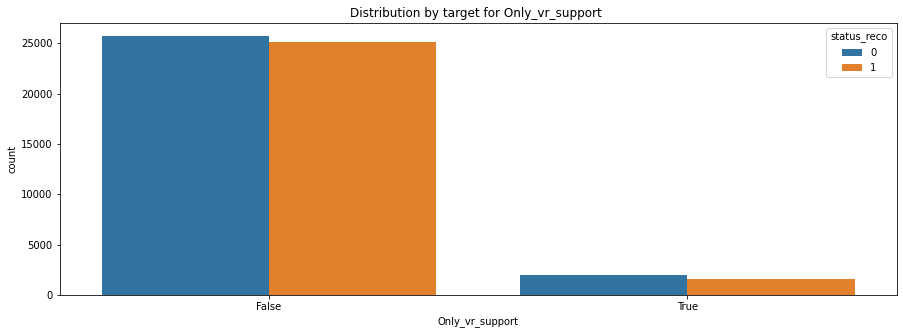

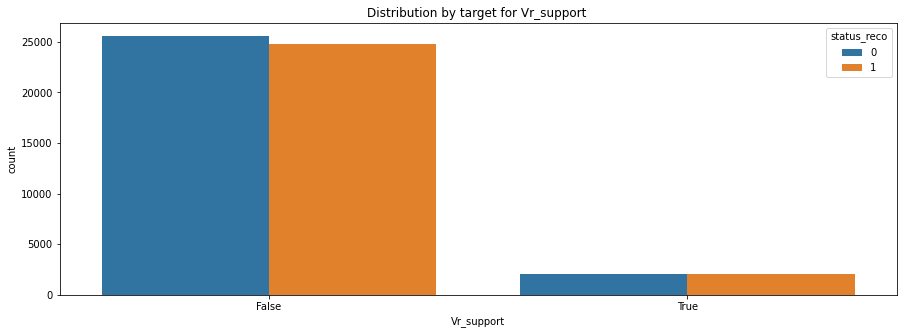

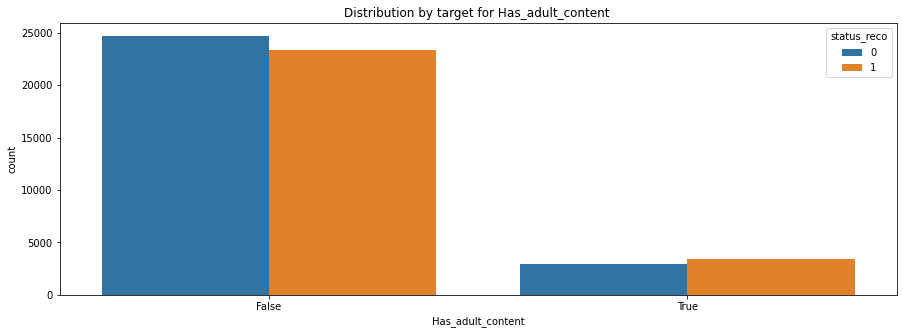

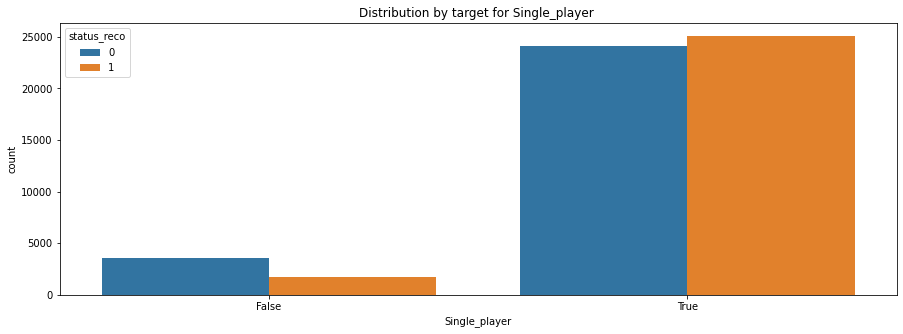

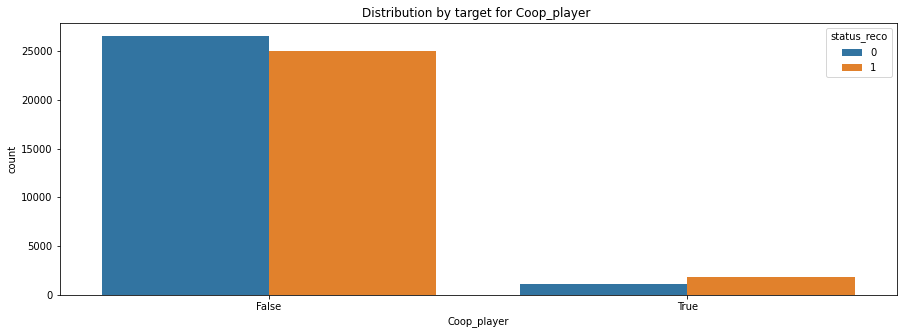

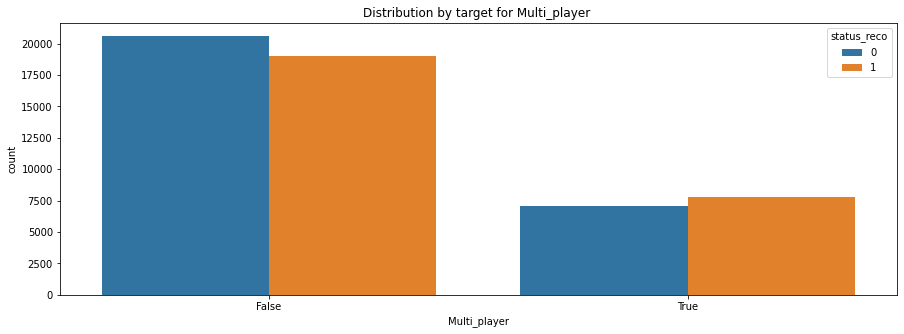

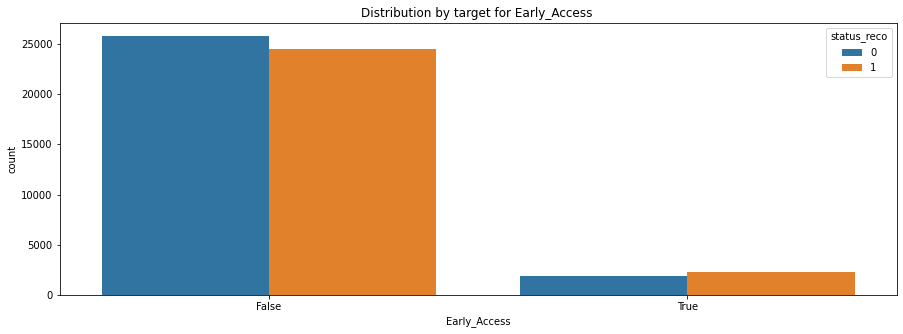

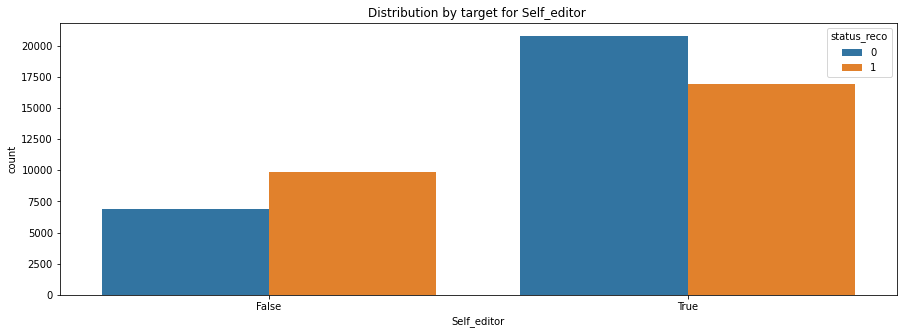

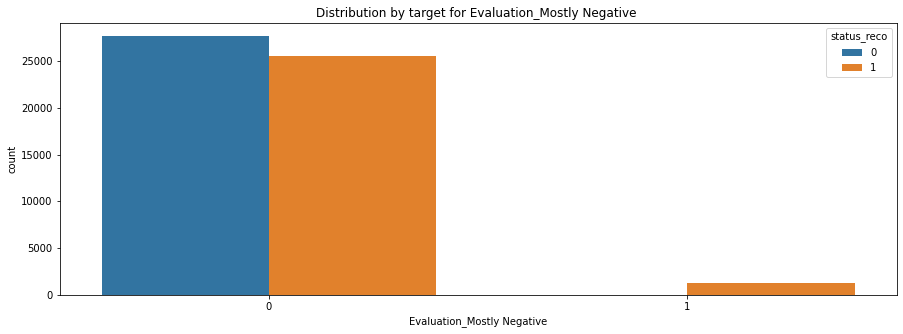

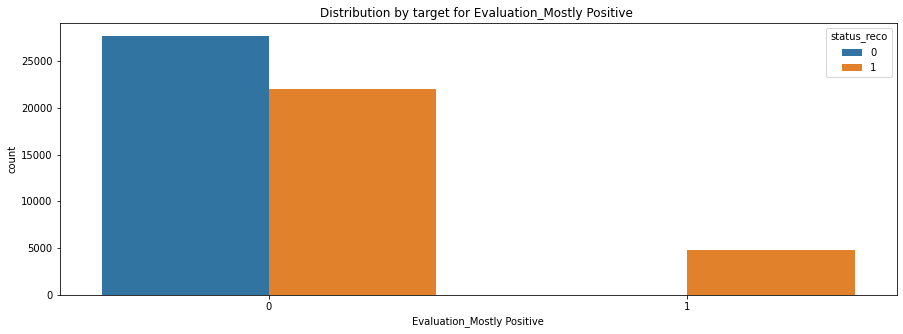

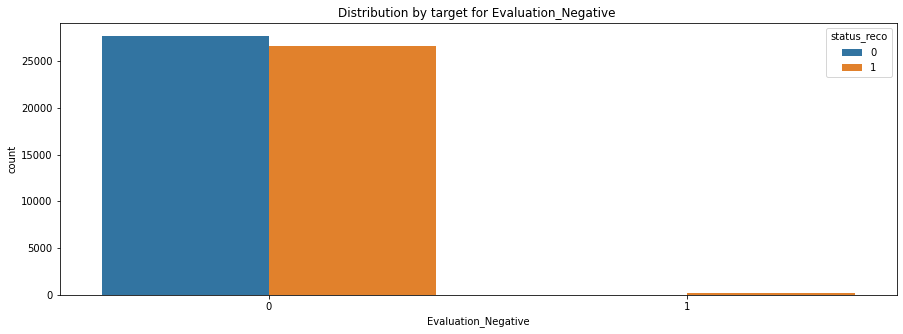

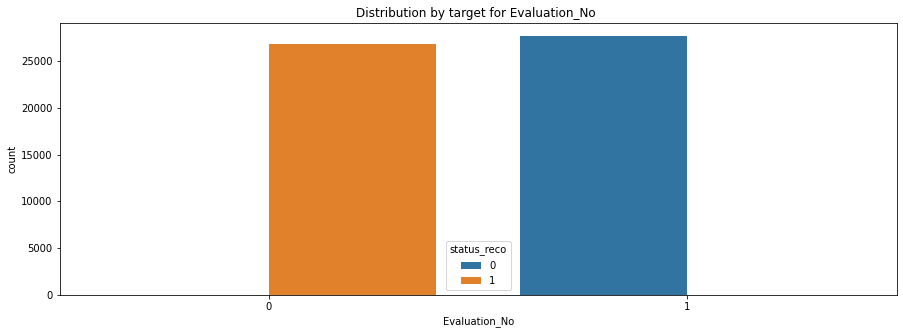

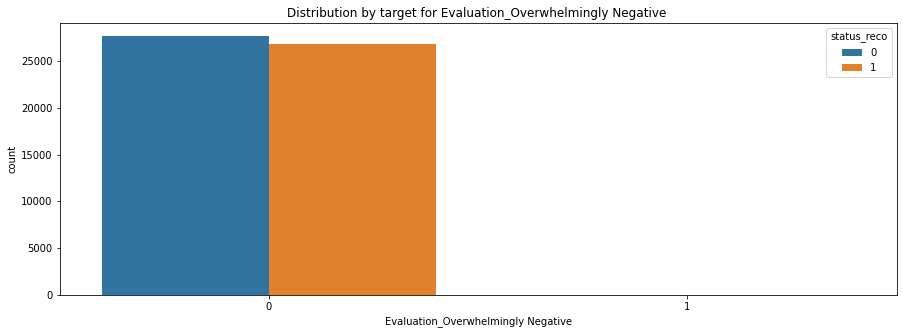

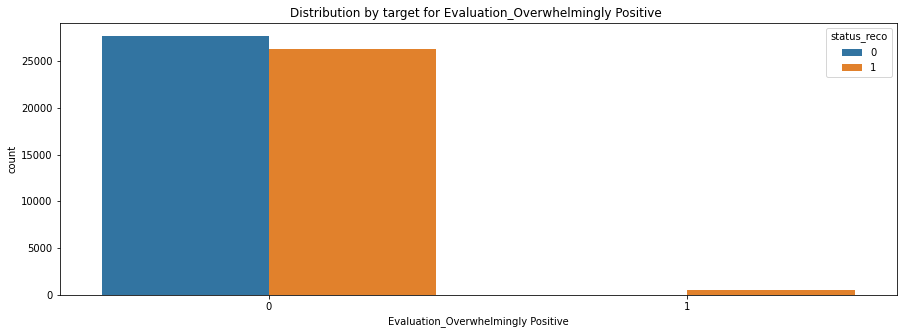

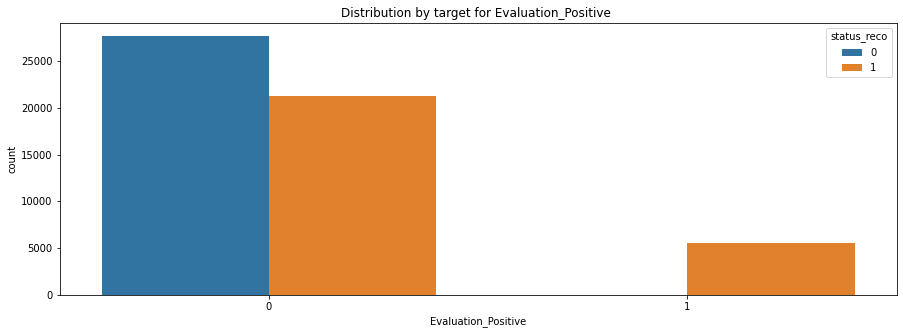

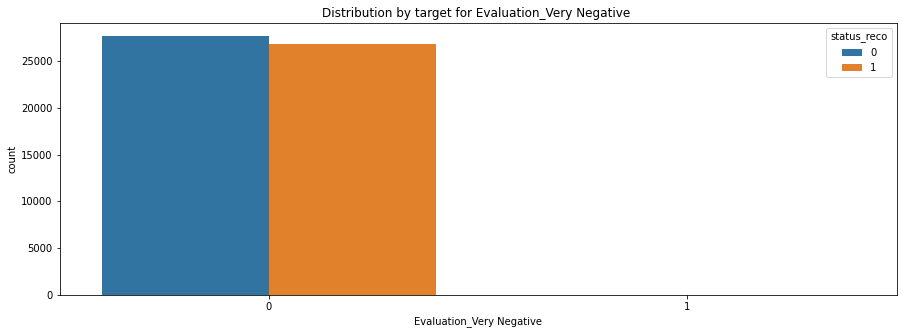

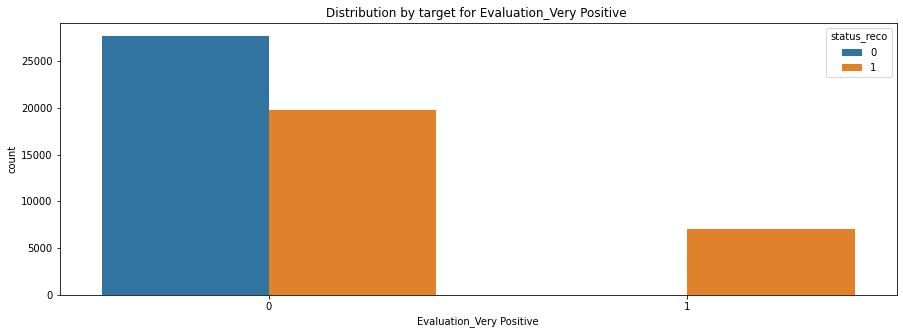

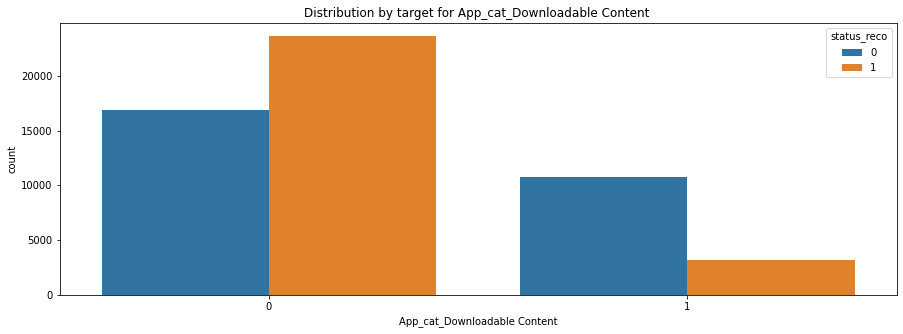

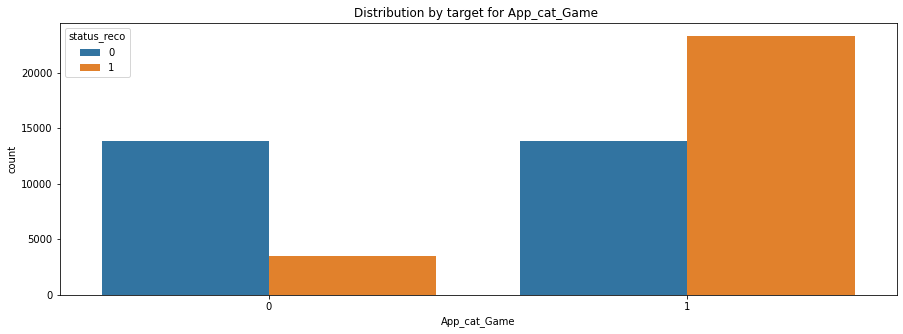

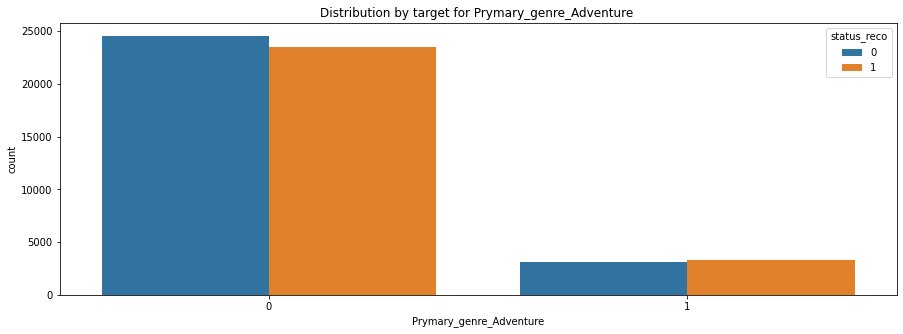

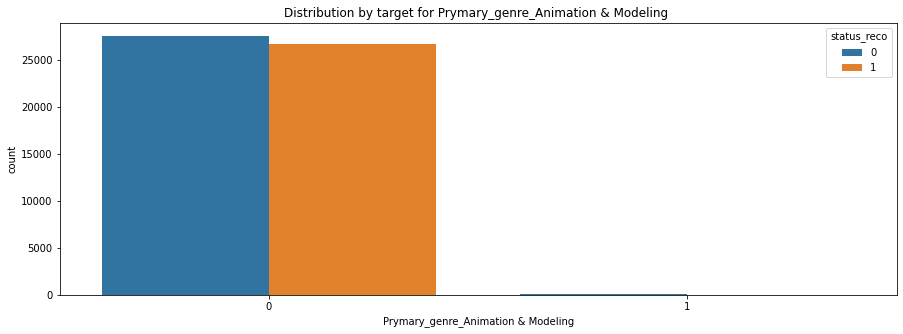

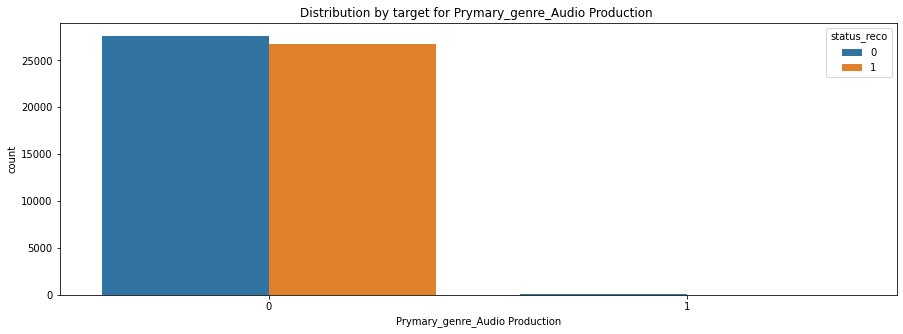

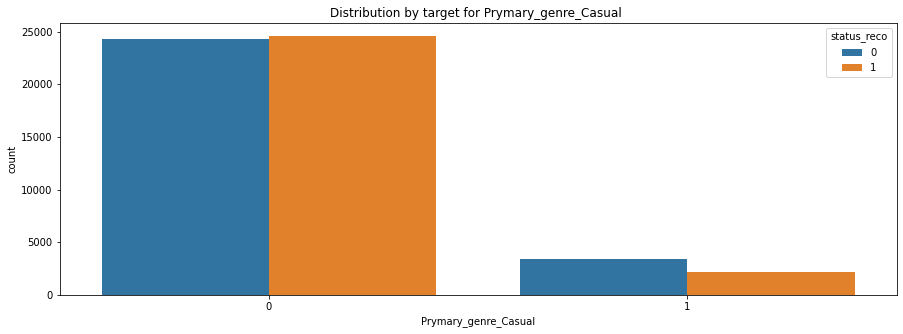

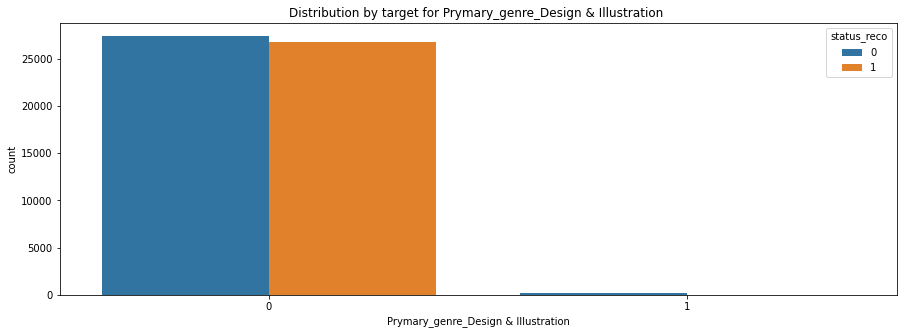

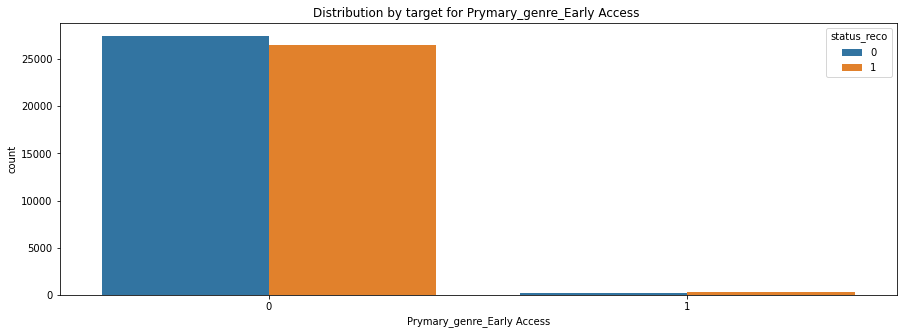

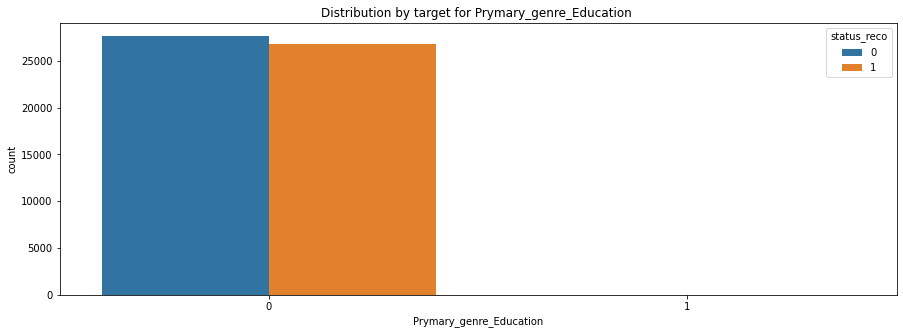

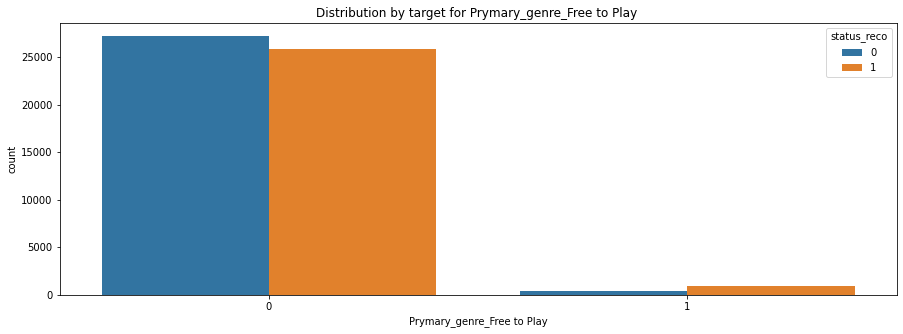

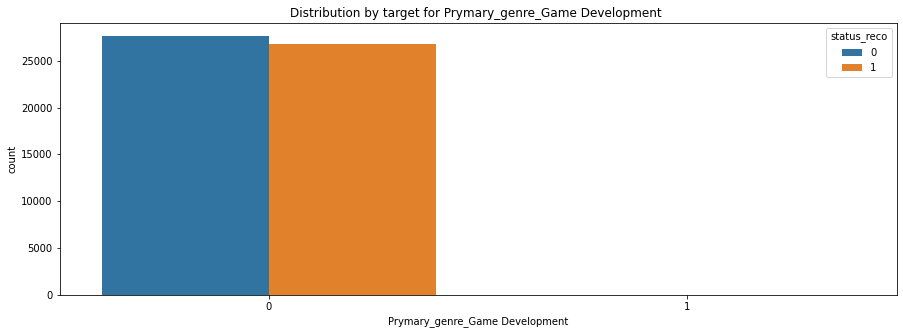

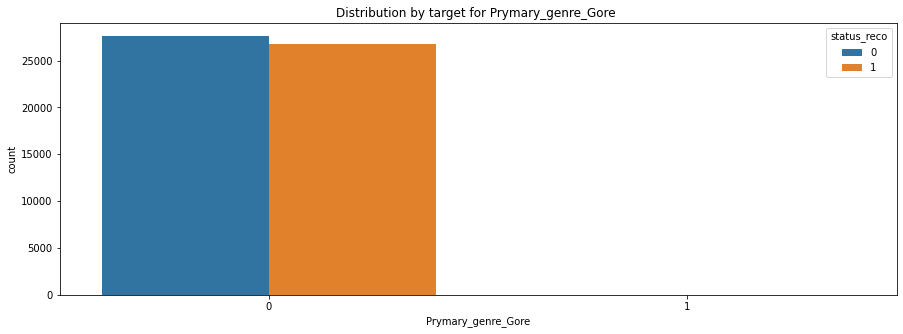

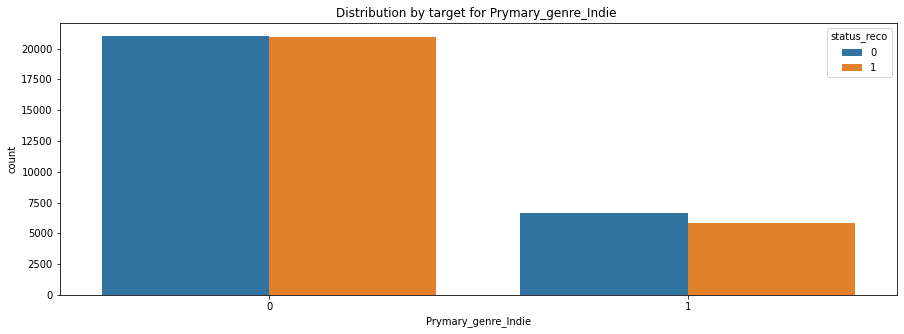

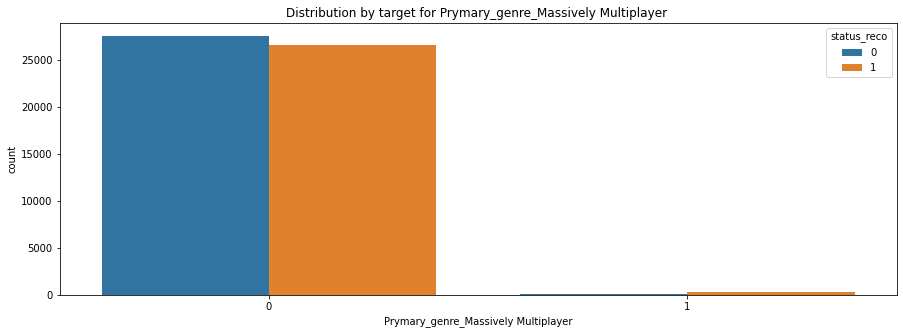

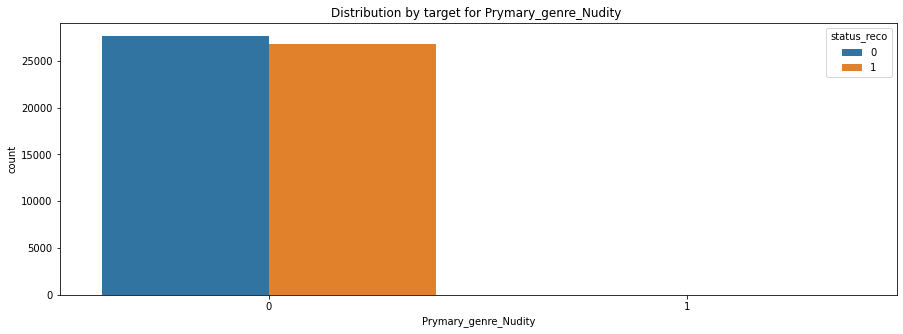

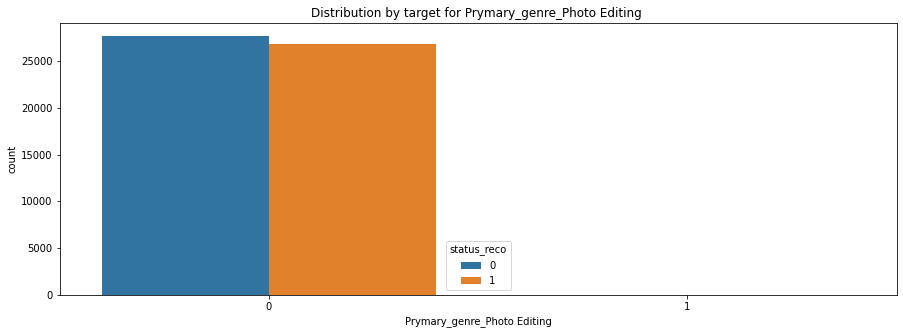

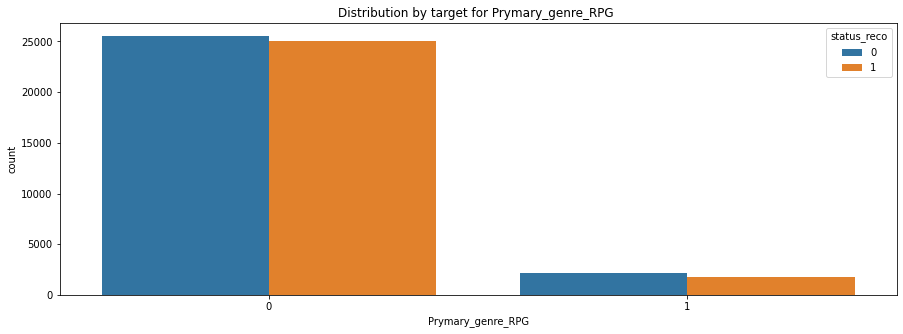

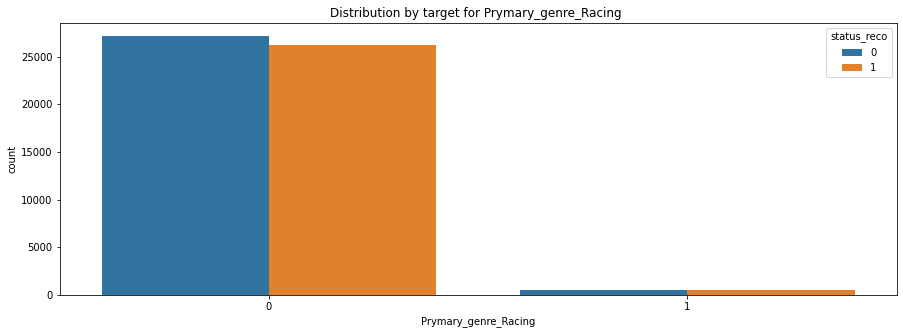

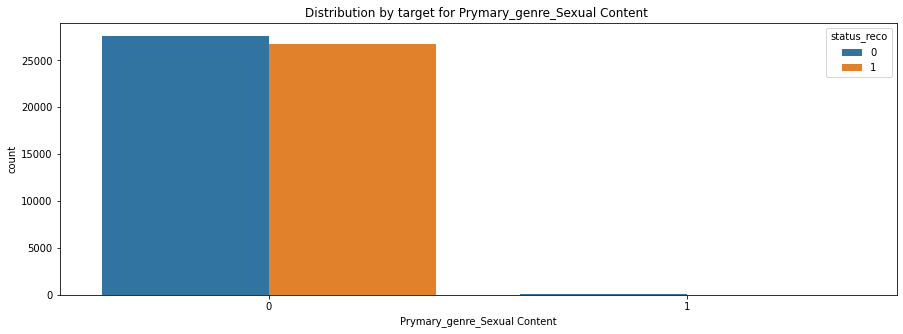

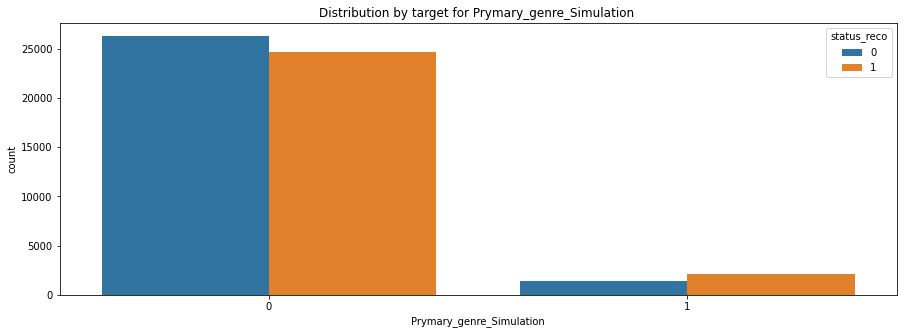

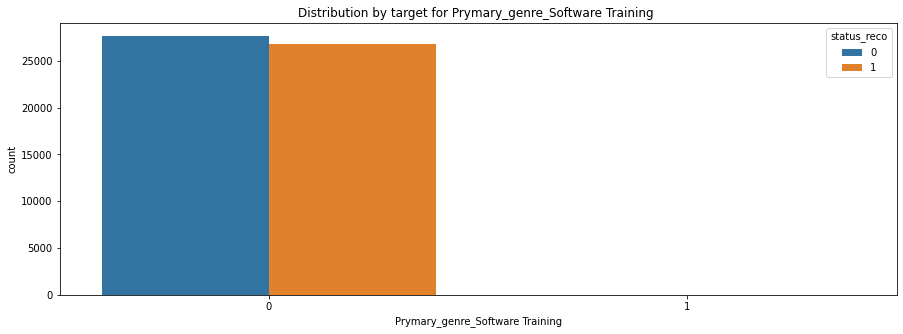

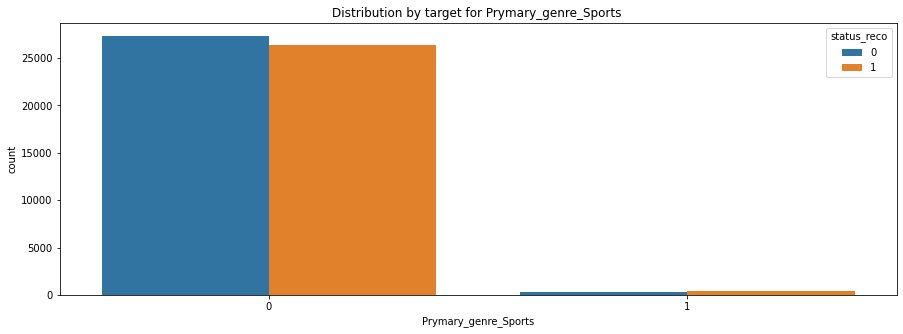

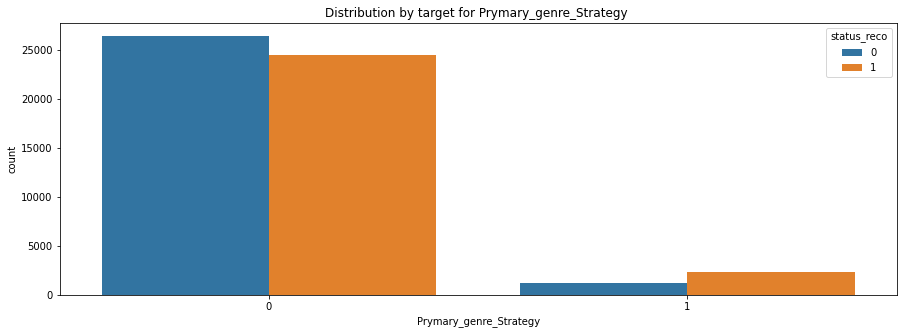

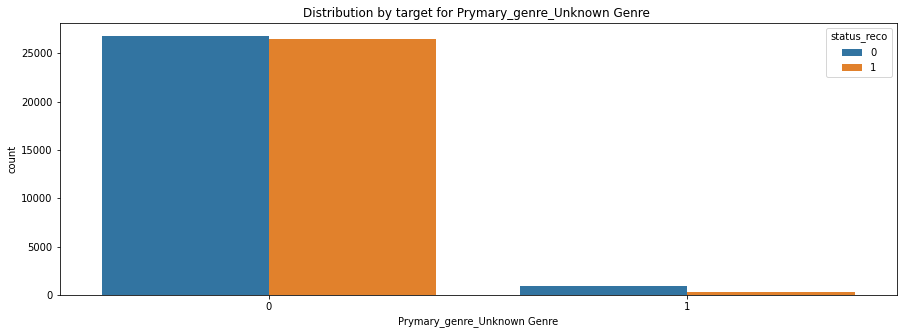

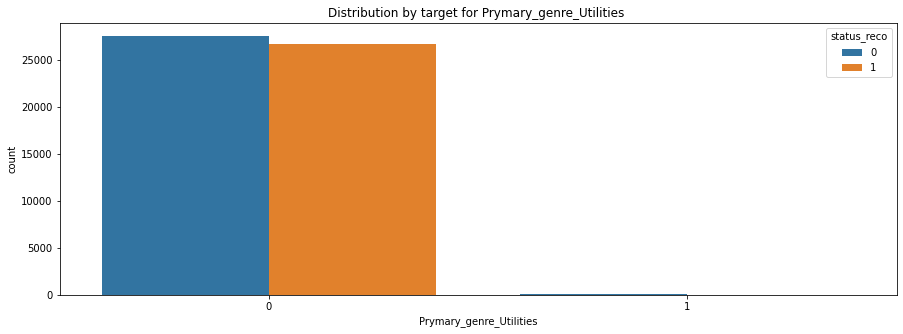

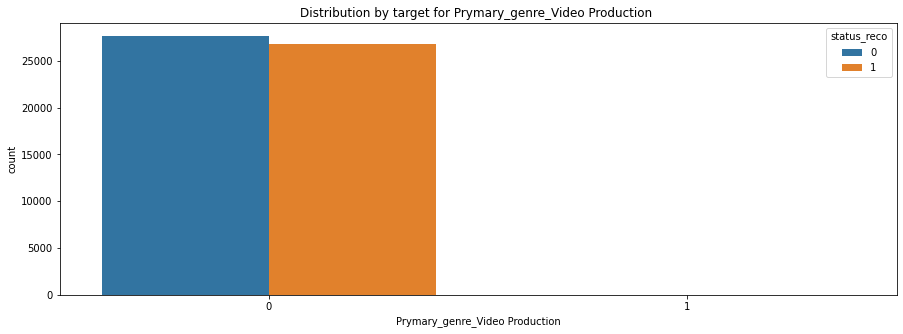

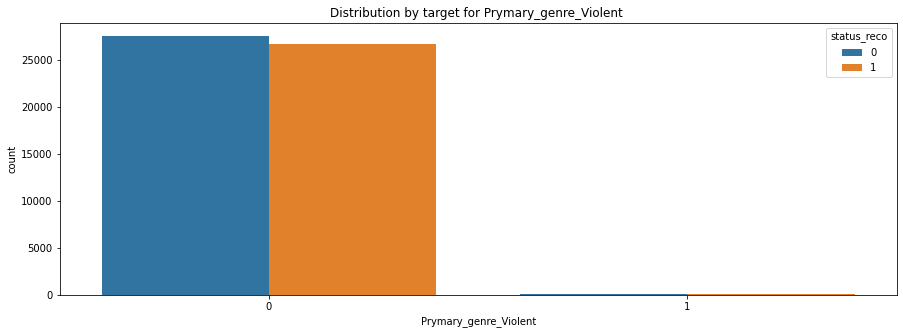

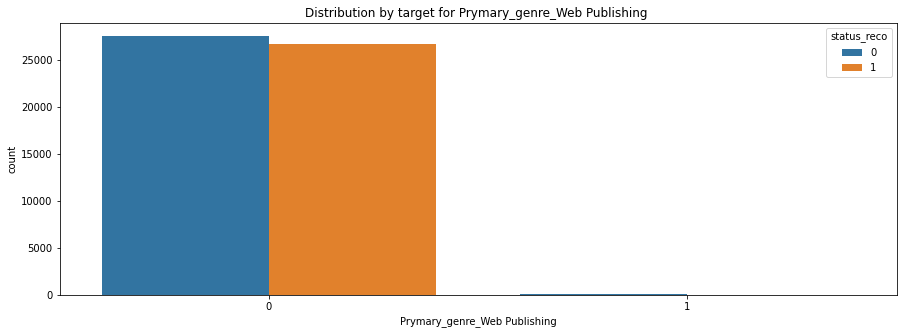

In [34]:
dataviz.all_dum_features_distribution()

# Modelisation

In [35]:
df_ph1 = df_clean.drop(columns=["Evaluation", "Nb_Eval", "Value_reco"])

In [36]:
## select dic of model
dict_models ={"Random Forest ":RandomForestClassifier(),
              "Gradient Boosting Classifier": GradientBoostingClassifier(),
              "AdaBoost Classifier": AdaBoostClassifier(),
              "XgBoost": xgb.XGBClassifier(),
              "Bagging" : BaggingClassifier(),
              "Decision Tree": DecisionTreeClassifier()}

## define var's for our class
test_size = 0.3 
random_state = 147


*********  Random Forest   *********

Score train : 0.98
-----------
Score test : 0.78
-----------
AUC: 0.81 (std:0.0215), (splits = 3)


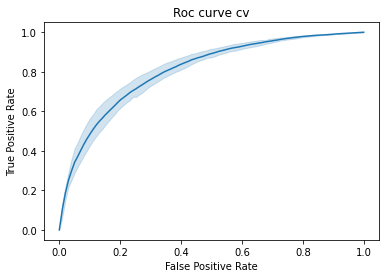

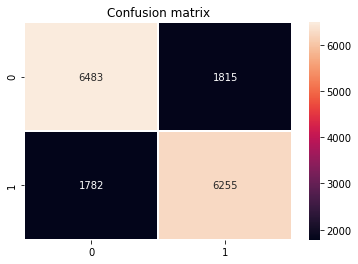

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      8298
           1       0.78      0.78      0.78      8037

    accuracy                           0.78     16335
   macro avg       0.78      0.78      0.78     16335
weighted avg       0.78      0.78      0.78     16335


*********  Gradient Boosting Classifier  *********

Score train : 0.77
-----------
Score test : 0.77
-----------
AUC: 0.83 (std:0.0268), (splits = 3)


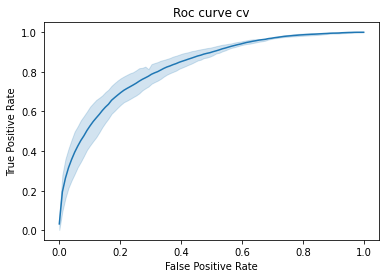

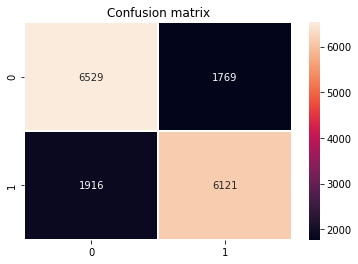

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      8298
           1       0.78      0.76      0.77      8037

    accuracy                           0.77     16335
   macro avg       0.77      0.77      0.77     16335
weighted avg       0.77      0.77      0.77     16335


*********  AdaBoost Classifier  *********

Score train : 0.76
-----------
Score test : 0.76
-----------
AUC: 0.82 (std:0.0303), (splits = 3)


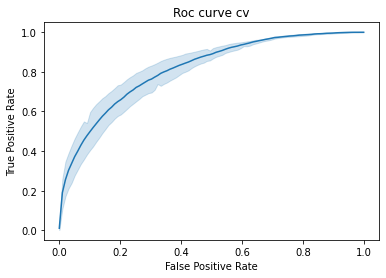

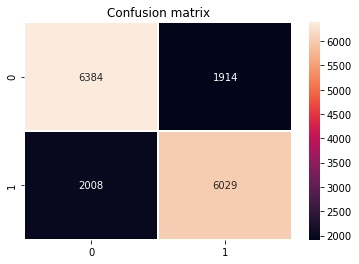

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      8298
           1       0.76      0.75      0.75      8037

    accuracy                           0.76     16335
   macro avg       0.76      0.76      0.76     16335
weighted avg       0.76      0.76      0.76     16335


*********  XgBoost  *********

Score train : 0.77
-----------
Score test : 0.77
-----------
AUC: 0.83 (std:0.0277), (splits = 3)


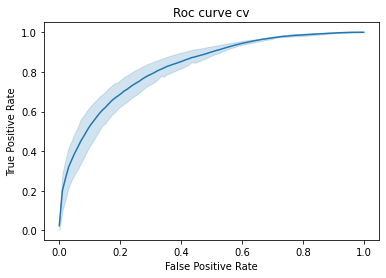

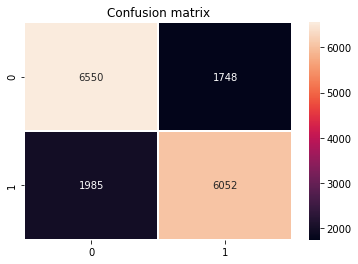

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      8298
           1       0.78      0.75      0.76      8037

    accuracy                           0.77     16335
   macro avg       0.77      0.77      0.77     16335
weighted avg       0.77      0.77      0.77     16335


*********  Bagging  *********

Score train : 0.97
-----------
Score test : 0.76
-----------
AUC: 0.78 (std:0.0149), (splits = 3)


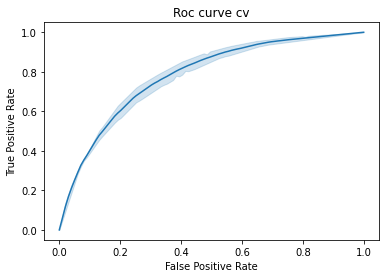

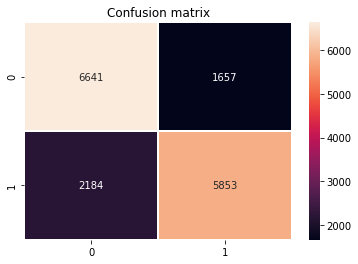

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      8298
           1       0.78      0.73      0.75      8037

    accuracy                           0.76     16335
   macro avg       0.77      0.76      0.76     16335
weighted avg       0.77      0.76      0.76     16335


*********  Decision Tree  *********

Score train : 0.98
-----------
Score test : 0.74
-----------
AUC: 0.68 (std:0.016), (splits = 3)


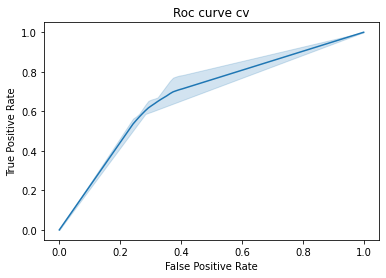

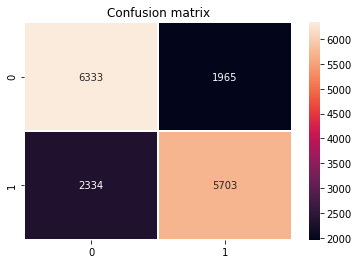

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      8298
           1       0.74      0.71      0.73      8037

    accuracy                           0.74     16335
   macro avg       0.74      0.74      0.74     16335
weighted avg       0.74      0.74      0.74     16335



In [37]:
for name, model in dict_models.items():
    print("")
    print("********* ",name," *********")
    print("")
    model_fited, _ = MainAiJob(model, df_ph1, target_name='status_reco', catagorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=False, normalize=True,
                        list_col_name_drop=None,show_explainers=False, calibrate_model=False)

In [38]:
model_selec = GradientBoostingClassifier()

Score train : 0.77
-----------
Score test : 0.77
-----------
AUC: 0.83 (std:0.0268), (splits = 3)


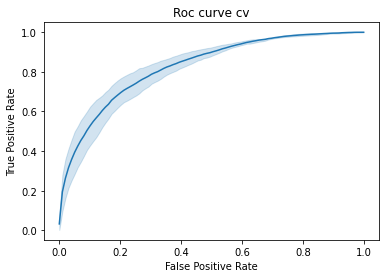

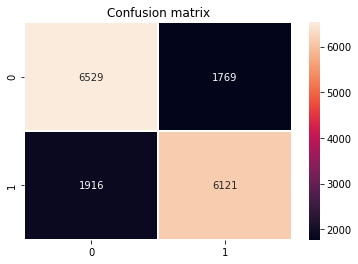

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      8298
           1       0.78      0.76      0.77      8037

    accuracy                           0.77     16335
   macro avg       0.77      0.77      0.77     16335
weighted avg       0.77      0.77      0.77     16335



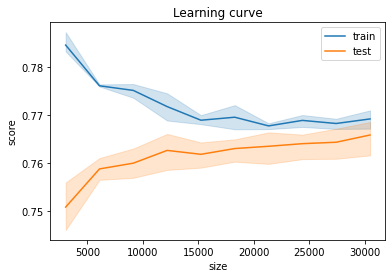

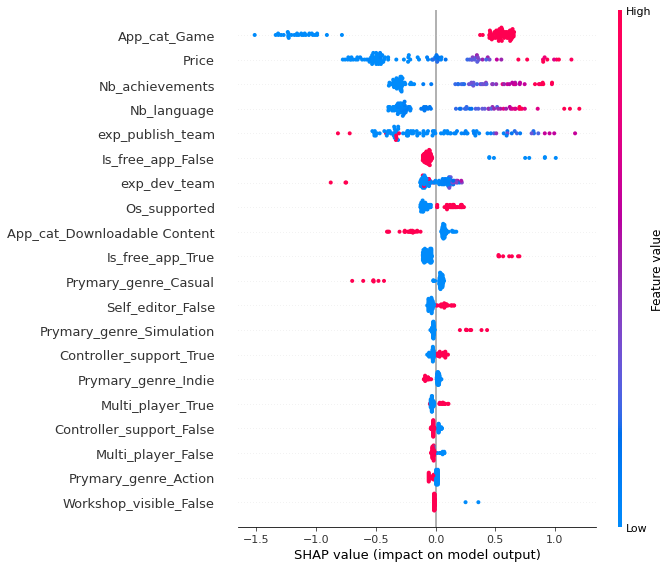

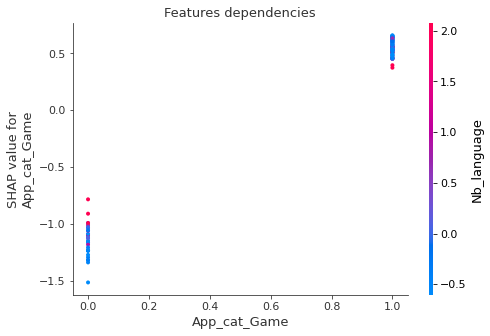

In [39]:
model_fited, core = MainAiJob(model_selec, df_ph1, target_name='status_reco', catagorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=True, normalize=True,
                        list_col_name_drop=None,show_explainers=True, calibrate_model=False)

In [40]:
model_fited

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Os_supported',
                                                   'Nb_language',
                                                   'Nb_achievements', 'Price',
                                                   'exp_dev_team',
                                                   'exp_publish_team']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['App_cat', 'Prymary_genre',
                                                   'Controller_support

# Validation

In [39]:
val_data = pd.read_csv("../DataTemplates/steam/steam_val.csv", index_col=0)

In [40]:
val_data

,App_cat,Os_supported,Prymary_genre,Controller_support,Is_free_app,Nb_language,Workshop_visible,Only_vr_support,Vr_support,Has_adult_content,Nb_achievements,Single_player,Coop_player,Multi_player,Early_Access,Price,exp_dev_team,exp_publish_team,Self_editor
1097150,Game,1,Action,1,0,21,0,0,0,0,34,0,1,1,0,19.00,8.0,120.0,0
1431550,Game,1,Action,1,0,3,0,0,0,0,0,1,0,1,0,2.39,0.0,0.0,1


In [45]:
val_data.shape

(2, 19)

In [41]:
y_val = [1,0]

In [42]:
m_val_step = consume_validation.ConsumeModelClf(val_data,model_fited,validation=True,true_y=y_val)

m_val_step.predict_job()
final_df = m_val_step.show_result()
final_df

Score Validation : 1.0


,Id,Predictions,Trust%,True_value
0,1097150,1,98.00,1
1,1431550,0,75.67,0


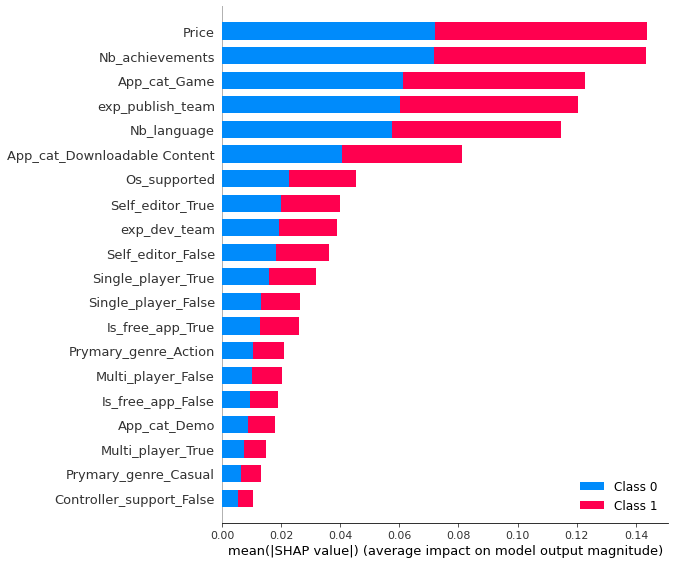

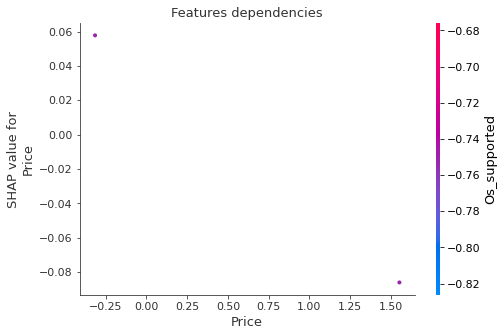

In [43]:
m_val_step.explain(shap_mod=False, list_cat_features=cols_cat,list_num_features=col_num,
                   pipeline_is_normalized=True)

In [41]:
dump_new = False

if dump_new:
    dump(model_fited,'../Model/gbc_f1.joblib')

# Phase 2

In [36]:
## This df will be used for create train/test on phase 2 & 3
df_ph2 = df_clean[df_clean["status_reco"].isin([1])]
df_ph2.shape 

(26789, 23)

In [38]:
df_ph2_clean = df_ph2.drop(['Nb_Eval','Evaluation','status_reco'], axis=1)
df_ph2_clean.sample()

,App_cat,Os_supported,Prymary_genre,Controller_support,Is_free_app,Nb_language,Workshop_visible,Only_vr_support,Vr_support,Has_adult_content,Nb_achievements,Single_player,Coop_player,Multi_player,Early_Access,Price,Value_reco,exp_dev_team,exp_publish_team,Self_editor
15579,Game,4,Adventure,True,False,25,False,False,False,False,23,True,False,True,False,12.49,1,2.0,2.0,True



*********  Random Forest   *********

Score train : 0.98
-----------
Score test : 0.69
-----------
AUC: 0.63 (std:0.01), (splits = 3)


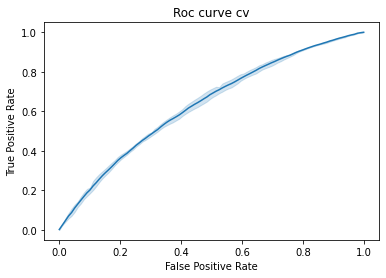

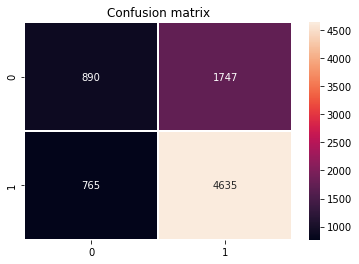

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.54      0.34      0.41      2637
           1       0.73      0.86      0.79      5400

    accuracy                           0.69      8037
   macro avg       0.63      0.60      0.60      8037
weighted avg       0.66      0.69      0.66      8037


*********  Gradient Boosting Classifier  *********

Score train : 0.7
-----------
Score test : 0.69
-----------
AUC: 0.65 (std:0.0127), (splits = 3)


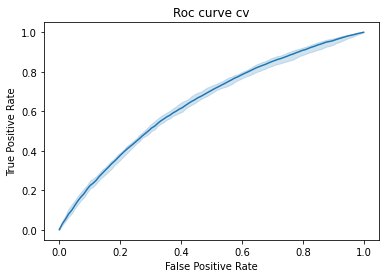

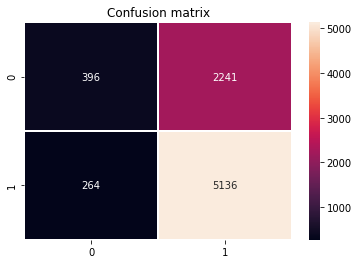

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.60      0.15      0.24      2637
           1       0.70      0.95      0.80      5400

    accuracy                           0.69      8037
   macro avg       0.65      0.55      0.52      8037
weighted avg       0.66      0.69      0.62      8037


*********  AdaBoost Classifier  *********

Score train : 0.69
-----------
Score test : 0.68
-----------
AUC: 0.63 (std:0.0116), (splits = 3)


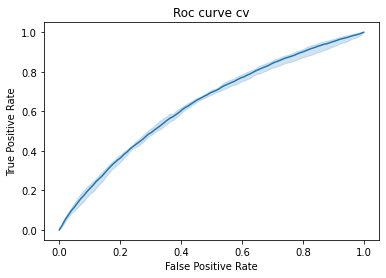

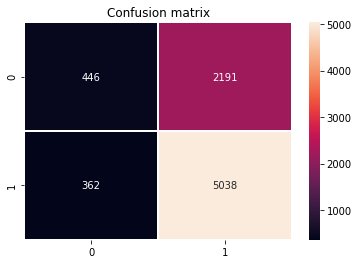

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.55      0.17      0.26      2637
           1       0.70      0.93      0.80      5400

    accuracy                           0.68      8037
   macro avg       0.62      0.55      0.53      8037
weighted avg       0.65      0.68      0.62      8037


*********  XgBoost  *********

Score train : 0.7
-----------
Score test : 0.69
-----------
AUC: 0.64 (std:0.0126), (splits = 3)


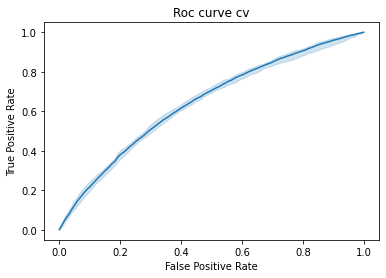

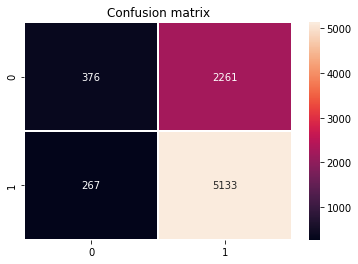

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.58      0.14      0.23      2637
           1       0.69      0.95      0.80      5400

    accuracy                           0.69      8037
   macro avg       0.64      0.55      0.52      8037
weighted avg       0.66      0.69      0.61      8037


*********  Bagging  *********

Score train : 0.97
-----------
Score test : 0.66
-----------
AUC: 0.6 (std:0.0107), (splits = 3)


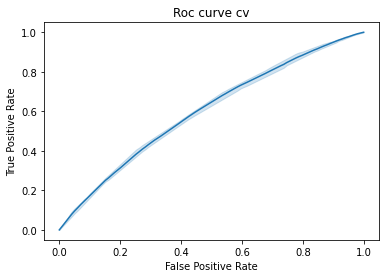

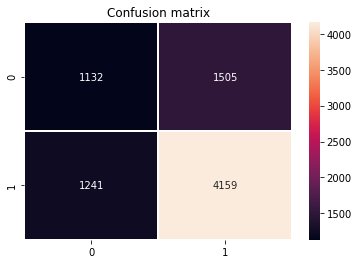

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.48      0.43      0.45      2637
           1       0.73      0.77      0.75      5400

    accuracy                           0.66      8037
   macro avg       0.61      0.60      0.60      8037
weighted avg       0.65      0.66      0.65      8037


*********  Decision Tree  *********

Score train : 0.98
-----------
Score test : 0.62
-----------
AUC: 0.55 (std:0.0037), (splits = 3)


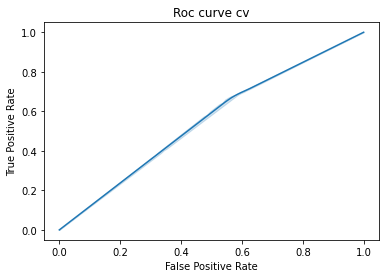

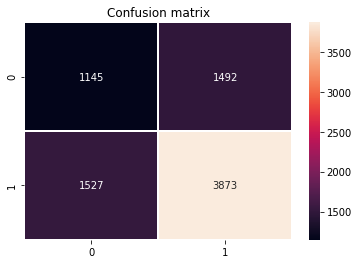

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.43      0.43      0.43      2637
           1       0.72      0.72      0.72      5400

    accuracy                           0.62      8037
   macro avg       0.58      0.58      0.58      8037
weighted avg       0.63      0.62      0.62      8037



In [28]:
for name, model in dict_models.items():
    print("")
    print("********* ",name," *********")
    print("")
    model_fited, _ = MainAiJob(model, df_ph2_clean, target_name='Value_reco', catagorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=False, normalize=True,
                        list_col_name_drop=None,show_explainers=False, calibrate_model=False)

In [29]:
model_selected_ph2 = GradientBoostingClassifier()

Score train : 0.7
-----------
Score test : 0.69
-----------
AUC: 0.65 (std:0.0127), (splits = 3)


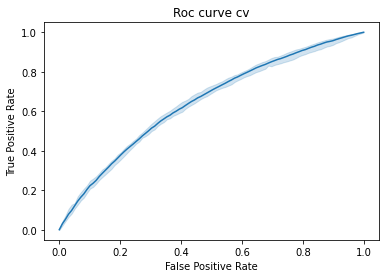

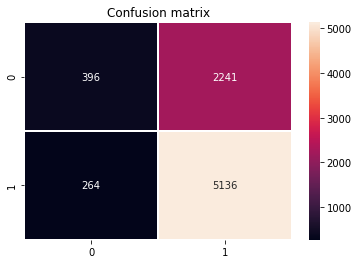

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.60      0.15      0.24      2637
           1       0.70      0.95      0.80      5400

    accuracy                           0.69      8037
   macro avg       0.65      0.55      0.52      8037
weighted avg       0.66      0.69      0.62      8037



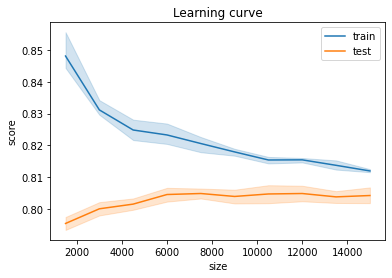

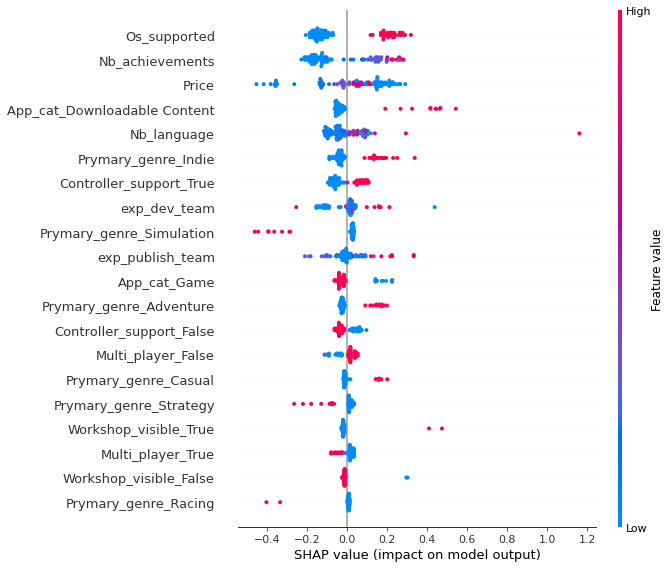

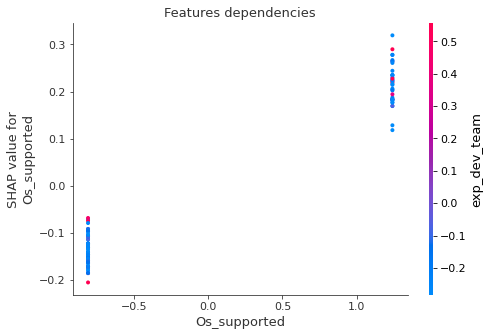

In [30]:
model_fited_ph2, core_ph2 = MainAiJob(model_selected_ph2, df_ph2_clean, target_name='Value_reco', catagorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=True, normalize=True,
                        list_col_name_drop=None,show_explainers=True, calibrate_model=False)

In [33]:
dump_new_ph2 = True

if dump_new_ph2:
    dump(model_fited_ph2,'../Model/gbc_ph2.joblib')

# Phase 3

In [40]:
df_ph3 = df_ph2.sort_values("Nb_Eval", axis = 0, ascending = False)
df_ph3.shape

(26789, 23)

In [41]:
df_ph3 = df_ph3.iloc[50:] ## remove 50 biger, (more thant 200 00)
df_ph3.shape

(26739, 23)

In [42]:
## and reset index
df_ph3 = df_ph3.reset_index(drop=True)

In [43]:
df_ph3.index

RangeIndex(start=0, stop=26739, step=1)

In [44]:
df_ph3['Nb_Eval_log'] = np.log(df_ph3.Nb_Eval)

<AxesSubplot:>

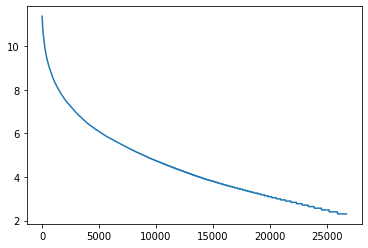

In [46]:
df_ph3['Nb_Eval_log'].plot()

In [74]:
y_full_f3 = df_ph3['Nb_Eval_log'].values

x_full_f3 = df_ph3.drop(['Nb_Eval','Evaluation','status_reco', 'Value_reco','Nb_Eval_log'], axis=1)
x_full_f3.shape, y_full_f3.shape

((26739, 19), (26739,))

In [75]:
seed = 60
np.random.seed(seed)

In [76]:
x_train_f3, x_val_f3, y_train_f3, y_val_f3 = train_test_split(x_full_f3, y_full_f3 , test_size=0.3, random_state=seed)
x_train_f3.shape, x_val_f3.shape, y_train_f3.shape, y_val_f3.shape

((18717, 19), (8022, 19), (18717,), (8022,))

In [77]:
preprocess = make_column_transformer( (MinMaxScaler(), ['Nb_language', 'Nb_achievements',
                                                          'exp_dev_team', 'exp_publish_team','Price']),
                                     (OneHotEncoder(handle_unknown='ignore'),['App_cat', 'Os_supported', 'Prymary_genre',
       'Controller_support', 'Is_free_app', 'Workshop_visible',
       'Only_vr_support', 'Vr_support', 'Has_adult_content',
       'Single_player', 'Coop_player', 'Multi_player', 'Early_Access', 'Self_editor']))

In [78]:
sgd_f3 = make_pipeline(preprocess,PolynomialFeatures(), SGDRegressor())
svrl_f3 = make_pipeline(preprocess,PolynomialFeatures(), svm.LinearSVR(max_iter=5000))
ridg_f3 = make_pipeline(preprocess,PolynomialFeatures(), Ridge(max_iter=1000))
svr_f3 = make_pipeline(preprocess, svm.SVR(C=1,kernel='poly'))

In [79]:
dict_models_f3 ={"SGD": sgd_f3,"SVRLR": svrl_f3,"Ridge": ridg_f3,"SVR": svr_f3}

In [80]:
def f3_eval(pip,x_train, x_val, y_train, y_val):
    print("---------------")
    pip.fit(x_train,y_train);
    y_valid_pred = pip.predict(x_val)

    pred_ref = np.exp(y_valid_pred)

    y_val_rescale = y_val.reshape(y_val.shape[0])
    y_val_rescale = np.exp(y_val_rescale)

    RMSE = np.sqrt(MSE(pred_ref, y_val_rescale))
    print('RMSE : ', RMSE.round(4))

    score = MAE(pred_ref, y_val_rescale)
    print('MAE : ', round(score,4))

    plt.figure()
    sns.regplot(pred_ref, y_val_rescale, color="g")
    plt.show()
    print("---------------")

SGD
---------------
RMSE :  4260.8005
MAE :  849.1601


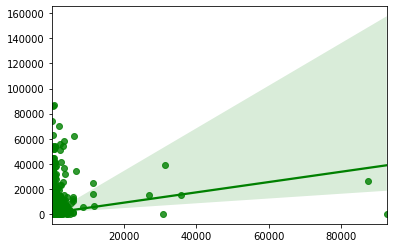

---------------
SVRLR
---------------


Liblinear failed to converge, increase the number of iterations.


RMSE :  6994.1686
MAE :  900.846


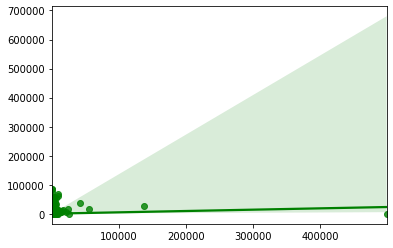

---------------
Ridge
---------------
RMSE :  4636.207
MAE :  862.8543


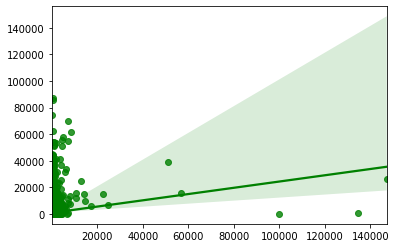

---------------
SVR
---------------
RMSE :  4078.6917
MAE :  828.881


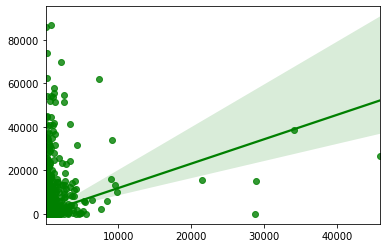

---------------


In [82]:
for name, model in dict_models_f3.items():
    print(name)
    f3_eval(model,x_train_f3, x_val_f3, y_train_f3, y_val_f3)

In [83]:
svr_f3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Nb_language',
                                                   'Nb_achievements',
                                                   'exp_dev_team',
                                                   'exp_publish_team',
                                                   'Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['App_cat', 'Os_supported',
                                                   'Prymary_genre',
                                                   'Controller_support',
                                                   'Is_free_app',
                                                   '

In [84]:
dump_new_ph3 = False

if dump_new_ph3 :
    dump(svr_f3, '../Model/svr_f3.joblib')